In [2]:
import numpy as np

data_path = "../../output/ml_training_dataset.npz"
data = np.load(data_path, mmap_mode='r')

waveforms = data['waveforms']                      # (N, T)
photon_times = data['photon_times_detected_jittered']  # (N, K)
time_axis = data['time_axis']                      # (T,)

N, T = waveforms.shape
rng = np.random.default_rng(42)
idx = rng.permutation(N)
n_train = int(0.7 * N)
n_val = int(0.2 * N)
n_test = N - n_train - n_val

train_idx = idx[:n_train]
val_idx   = idx[n_train:n_train+n_val]
test_idx  = idx[n_train+n_val:]

print(f"Total: events={N}, waveform shape=({N}, {T})")
print(f"Train: events={len(train_idx)}, waveform shape=({len(train_idx)}, {T})")
print(f"Valid: events={len(val_idx)}, waveform shape=({len(val_idx)}, {T})")
print(f"Test:  events={len(test_idx)}, waveform shape=({len(test_idx)}, {T})")

Total: events=112847, waveform shape=(112847, 1021)
Train: events=78992, waveform shape=(78992, 1021)
Valid: events=22569, waveform shape=(22569, 1021)
Test:  events=11286, waveform shape=(11286, 1021)


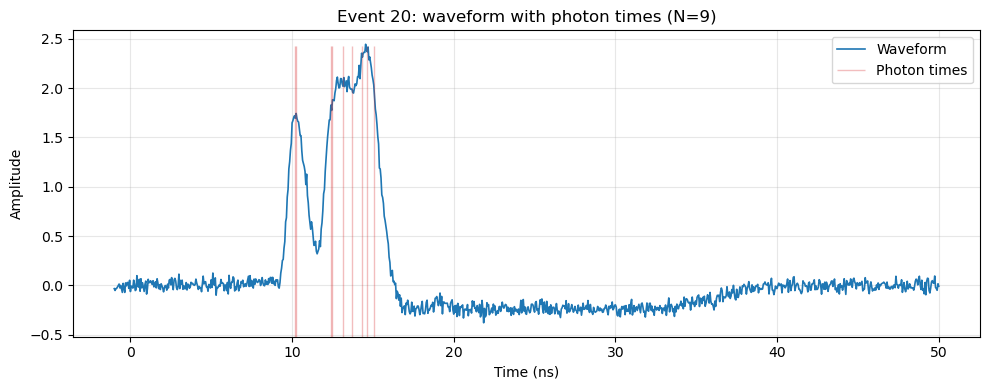

In [13]:
import matplotlib.pyplot as plt
I = 20  # change to the event index you want to inspect

w = waveforms[I]
t = time_axis
pt = photon_times[I]
pt = pt[~np.isnan(pt)]

fig, ax = plt.subplots(figsize=(10, 4))
line_wf, = ax.plot(t, w, lw=1.2, color='tab:blue', label='Waveform')
yl = ax.get_ylim()
if pt.size > 0:
    ax.vlines(pt, yl[0], yl[0] + 0.95*(yl[1]-yl[0]), color='tab:red', alpha=0.3, lw=1, label='Photon times')
    ax.set_ylim(yl)  # keep original y-limits

ax.set_xlabel('Time (ns)')
ax.set_ylabel('Amplitude')
ax.set_title(f'Event {I}: waveform with photon times (N={pt.size})')
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

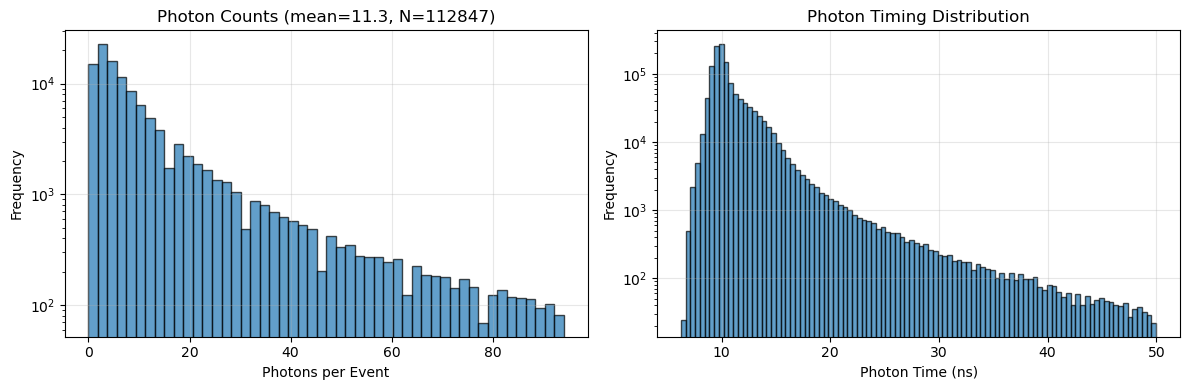

In [4]:
import matplotlib.pyplot as plt

counts = np.sum(~np.isnan(photon_times), axis=1)
all_times = photon_times[~np.isnan(photon_times)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(counts, bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Photons per Event')
ax1.set_ylabel('Frequency')
ax1.set_yscale('log')
ax1.set_title(f'Photon Counts (mean={counts.mean():.1f}, N={len(counts)})')
ax1.grid(True, alpha=0.3)

ax2.hist(all_times, bins=100, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Photon Time (ns)')
ax2.set_ylabel('Frequency')
ax2.set_yscale('log')
ax2.set_title('Photon Timing Distribution')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
#!/usr/bin/env python3
"""Simple 1D CNN for photon deconvolution"""
import tensorflow as tf
import numpy as np

# Configuration
config = {
    'filters': [16, 8], 'kernels': [9, 7, 5], 'output_bins': 1021,
    'lr': 1e-3, 'batch_size': 128, 'epochs': 10,
    'lr_patience': 5, 'early_patience': 15
}

def load_data():
    """Load and split dataset"""
    data = np.load("../../output/ml_training_dataset.npz", mmap_mode='r')
    waveforms, photon_times, time_axis = data['waveforms'], data['photon_times_detected_jittered'], data['time_axis']
    
    N = len(waveforms)
    idx = np.random.RandomState(42).permutation(N)
    splits = [int(0.7*N), int(0.9*N)]
    train_idx, val_idx, test_idx = idx[:splits[0]], idx[splits[0]:splits[1]], idx[splits[1]:]
    
    return waveforms, photon_times, time_axis, (train_idx, val_idx, test_idx)

def create_targets(photon_times, time_axis):
    """Convert photon times to time-aligned counts"""
    targets = np.zeros((len(photon_times), len(time_axis)), dtype=np.float32)
    for i, times in enumerate(photon_times):
        valid_times = times[~np.isnan(times)]
        if len(valid_times) > 0:
            # Map each photon time to nearest time_axis index
            indices = np.searchsorted(time_axis, valid_times)
            indices = np.clip(indices, 0, len(time_axis) - 1)
            # Count photons at each time point
            unique_indices, counts = np.unique(indices, return_counts=True)
            targets[i, unique_indices] = counts.astype(np.float32)
    return targets

def build_model(input_len, cfg):
    """Build 3-layer CNN"""
    x = inputs = tf.keras.Input(shape=(input_len,))
    x = tf.keras.layers.Reshape((input_len, 1))(x)
    x = tf.keras.layers.Conv1D(cfg['filters'][0], cfg['kernels'][0], activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv1D(cfg['filters'][1], cfg['kernels'][1], activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv1D(1, cfg['kernels'][2], activation='relu', padding='same')(x)
    outputs = tf.keras.layers.Reshape((input_len,))(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(cfg['lr']), loss='poisson', metrics=['mae'])
    return model

def train_model(model, X_train, y_train, X_val, y_val, cfg):
    """Train with callbacks"""
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(patience=cfg['lr_patience'], factor=0.5, min_lr=1e-6),
        tf.keras.callbacks.EarlyStopping(patience=cfg['early_patience'], restore_best_weights=True)
    ]
    return model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    batch_size=cfg['batch_size'], epochs=cfg['epochs'], callbacks=callbacks)

def plot_history(history):
    """Plot training history"""
    import matplotlib.pyplot as plt
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Poisson Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(history.history['mae'], label='Train MAE')
    ax2.plot(history.history['val_mae'], label='Val MAE')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Load data
    waveforms, photon_times, time_axis, (train_idx, val_idx, test_idx) = load_data()
    targets = create_targets(photon_times, time_axis)
    
    X_train, y_train = waveforms[train_idx], targets[train_idx]
    X_val, y_val = waveforms[val_idx], targets[val_idx]
    X_test, y_test = waveforms[test_idx], targets[test_idx]
    
    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    
    # Build and train
    model = build_model(waveforms.shape[1], config)
    print(f"Model parameters: {model.count_params()}")
    model.summary()
    
    history = train_model(model, X_train, y_train, X_val, y_val, config)
    model.save('photon_deconv_model.h5')
    
    # Show training history
    plot_history(history)
    
    # Test set evaluation - pred vs truth scatter plot
    y_pred = model.predict(X_test)
    
    # Calculate total photon counts per waveform
    pred_counts = np.sum(y_pred, axis=1)
    true_counts = np.sum(y_test, axis=1)
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.scatter(true_counts, pred_counts, alpha=0.5, s=10)
    plt.plot([0, true_counts.max()], [0, true_counts.max()], 'r--', label='Perfect prediction')
    plt.xlabel('True photon count')
    plt.ylabel('Predicted photon count')
    plt.title('Photon Count: Prediction vs Truth (Test Set)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Calculate metrics
    mae = np.mean(np.abs(pred_counts - true_counts))
    rmse = np.sqrt(np.mean((pred_counts - true_counts)**2))
    plt.text(0.05, 0.95, f'MAE: {mae:.2f}\nRMSE: {rmse:.2f}', 
             transform=plt.gca().transAxes, verticalalignment='top')
    
    plt.show()
    print("Training complete, model saved!")

Train: (78992, 1021), Val: (22570, 1021), Test: (11285, 1021)
Model parameters: 1105


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1021)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 1021, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 1021, 16)       │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 1021, 8)        │           904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 1021, 1)        │            41 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 1021)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,105 (4.32 KB)

 Trainable params: 1,105 (4.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0273 - mae: 0.0174 - val_loss: 0.0229 - val_mae: 0.0137 - learning_rate: 0.0010
Epoch 2/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0229 - mae: 0.0139 - val_loss: 0.0223 - val_mae: 0.0136 - learning_rate: 0.0010
Epoch 3/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0226 - mae: 0.0140 - val_loss: 0.0221 - val_mae: 0.0139 - learning_rate: 0.0010
Epoch 4/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0223 - mae: 0.0138 - val_loss: 0.0221 - val_mae: 0.0139 - learning_rate: 0.0010
Epoch 5/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0224 - mae: 0.0139 - val_loss: 0.0221 - val_mae: 0.0140 - learning_rate: 0.0010
Epoch 6/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0228 - mae: 0.0144 - val_loss: 0.0227 - val_mae: 0.0147 - learning_rate: 0.0010
Epoch 7/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0227 - mae: 0.0141 - val_loss: 0.0222 - val_mae: 0.0136 - learning_rate: 0.0010

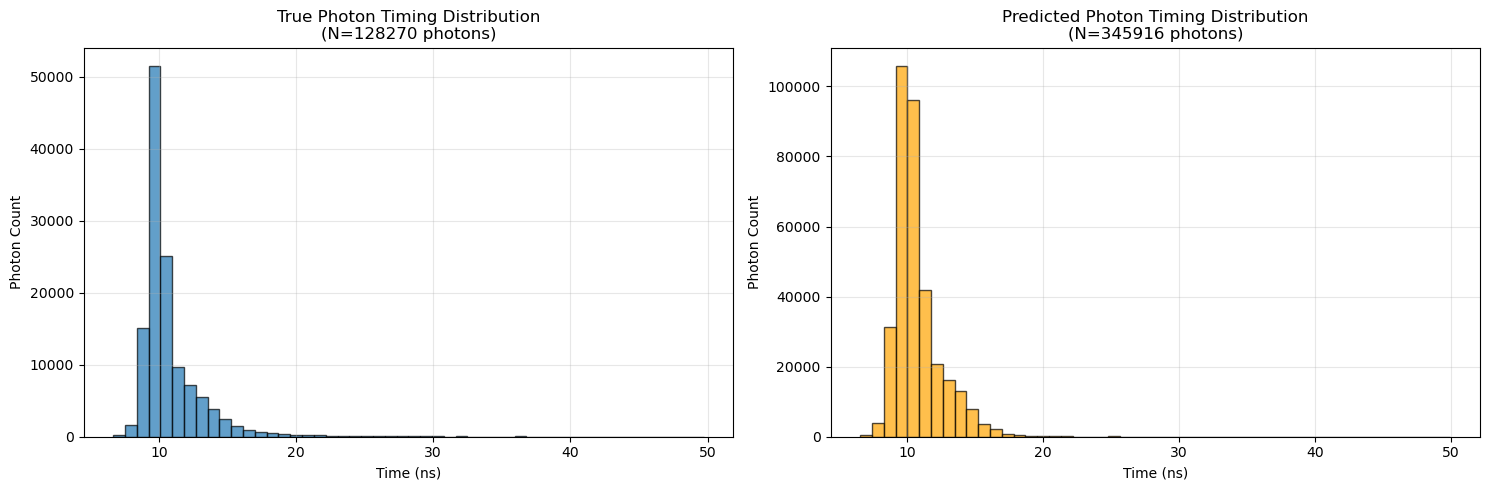

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# True photon times
all_true_times = []
for times in photon_times[test_idx]:
    valid_times = times[~np.isnan(times)]
    all_true_times.extend(valid_times)

ax1.hist(all_true_times, bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Photon Count')
ax1.set_title(f'True Photon Timing Distribution\n(N={len(all_true_times)} photons)')
ax1.grid(True, alpha=0.3)

# Predicted photon times (convert bin predictions to times)
all_pred_times = []
for pred in y_pred:
    # Find bins with predicted photons (above threshold)
    threshold = 0.1
    active_bins = np.where(pred > threshold)[0]
    for bin_idx in active_bins:
        # Add time for each predicted photon (rounded count)
        n_photons = max(1, int(np.round(pred[bin_idx])))
        photon_time = time_axis[bin_idx]
        all_pred_times.extend([photon_time] * n_photons)

ax2.hist(all_pred_times, bins=50, alpha=0.7, edgecolor='black', color='orange')
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Photon Count')
ax2.set_title(f'Predicted Photon Timing Distribution\n(N={len(all_pred_times)} photons)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()